In [5]:
import numpy as np
import pandas as pd

In [6]:
import pybamm
model = pybamm.lithium_ion.DFN()  # Doyle-Fuller-Newman model
sim = pybamm.Simulation(model)
sim.solve([0, 3600])  # solve for 1 hour
sim.plot()


interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [7]:
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from matplotlib.figure import Figure
import numpy as np

class Application(tk.Frame):
    def __init__(self, master=None):
        super().__init__(master)
        self.master = master
        self.master.title('Matplotlib in tkinter')
        self.pack()
        self.create_widgets()
        self.start_up()
        self.draw_plot()

    def create_widgets(self):
        self.canvas_frame = tk.Frame(self.master)
        self.canvas_frame.pack(side=tk.LEFT)
        self.control_frame = tk.Frame(self.master)
        self.control_frame.pack(side=tk.RIGHT)

        self.canvas = FigureCanvasTkAgg(fig, self.canvas_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        self.toolbar = NavigationToolbar2Tk(self.canvas, self.canvas_frame)
        self.toolbar.update()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        self.x_v = tk.DoubleVar()
        self.x_scale = tk.Scale(self.control_frame,
            variable=self.x_v,
            from_=0.0,
            to=10.0,
            resolution=0.1,
            orient=tk.HORIZONTAL,
            command=self.draw_plot)
        self.x_scale.pack(anchor=tk.NW)

        self.y_v = tk.DoubleVar()
        self.y_scale = tk.Scale(self.control_frame,
            variable=self.y_v,
            from_=0.0,
            to=10.0,
            resolution=0.1,
            orient=tk.HORIZONTAL,
            command=self.draw_plot)
        self.y_scale.pack(anchor=tk.NW)

    def start_up(self):
        self.x_v.set(1.0)
        self.y_v.set(1.0)

    def draw_plot(self, event=None):
        global h
        v = self.x_v.get()
        w = self.y_v.get()
        t = np.arange(0.0, 6.29, 0.01)
        x = np.cos(v * t)
        y = np.sin(w * t)
        h.set_xdata(x)
        h.set_ydata(y)
        self.canvas.draw()

fig = Figure(figsize=(5, 5), dpi=100)
ax = fig.add_subplot(111)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
h, = ax.plot([],[], 'green')

root = tk.Tk()
app = Application(master=root)
app.mainloop()

2023-07-16 09:31:51.834 - [NOTICE] callbacks.on_cycle_start(172): Cycle 1/3 (108.250 us elapsed) --------------------
2023-07-16 09:31:51.835 - [NOTICE] callbacks.on_step_start(180): Cycle 1/3, step 1/5: Discharge at 1C until 2.5 V
2023-07-16 09:31:52.087 - [NOTICE] callbacks.on_step_start(180): Cycle 1/3, step 2/5: Rest for 1 hour
2023-07-16 09:31:52.239 - [NOTICE] callbacks.on_step_start(180): Cycle 1/3, step 3/5: Charge at 5 A until 4.2 V
2023-07-16 09:31:52.491 - [NOTICE] callbacks.on_step_start(180): Cycle 1/3, step 4/5: Hold at 4.2 V until 10 mA
2023-07-16 09:31:52.860 - [NOTICE] callbacks.on_step_start(180): Cycle 1/3, step 5/5: Rest for 1 hour
2023-07-16 09:31:53.183 - [NOTICE] callbacks.on_cycle_start(172): Cycle 2/3 (1.349 s elapsed) --------------------
2023-07-16 09:31:53.184 - [NOTICE] callbacks.on_step_start(180): Cycle 2/3, step 1/5: Discharge at 1C until 2.5 V
2023-07-16 09:31:53.369 - [NOTICE] callbacks.on_step_start(180): Cycle 2/3, step 2/5: Rest for 1 hour
2023-07-1

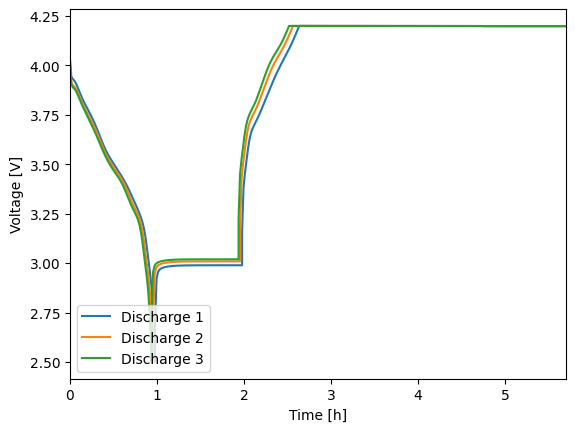

interactive(children=(FloatSlider(value=0.0, description='t', max=17.14137733095267, step=0.17141377330952667)…

In [9]:
#
# Constant-current constant-voltage charge
#
import pybamm
import matplotlib.pyplot as plt

pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1C until 2.5 V",
            "Rest for 1 hour",
            "Charge at 5 A until 4.2 V",
            "Hold at 4.2 V until 10 mA",
            "Rest for 1 hour",
        ),
    ]
    * 3
)
model = pybamm.lithium_ion.DFN({"SEI": "ec reaction limited"})
parameter_values = pybamm.ParameterValues("Chen2020")

sim = pybamm.Simulation(
    model,
    experiment=experiment,
    parameter_values=parameter_values,
    solver=pybamm.CasadiSolver("fast with events"),
)
sim.solve()

# Plot voltages from the discharge segments only
fig, ax = plt.subplots()
for i in range(3):
    # Extract sub solutions
    sol = sim.solution.cycles[i]
    # Extract variables
    t = sol["Time [h]"].entries
    V = sol["Voltage [V]"].entries
    # Plot
    ax.plot(t - t[0], V, label="Discharge {}".format(i + 1))
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Voltage [V]")
    ax.set_xlim([0, t[-1] - t[0]])
ax.legend(loc="lower left")

# Save time, voltage, current, discharge capacity, temperature, and electrolyte
# concentration to csv and matlab formats
sim.solution.save_data(
    "output.mat",
    [
        "Time [h]",
        "Current [A]",
        "Voltage [V]",
        "Discharge capacity [A.h]",
        "X-averaged cell temperature [K]",
        "Electrolyte concentration [mol.m-3]",
    ],
    to_format="matlab",
    short_names={
        "Time [h]": "t",
        "Current [A]": "I",
        "Voltage [V]": "V",
        "Discharge capacity [A.h]": "Q",
        "X-averaged cell temperature [K]": "T",
        "Electrolyte concentration [mol.m-3]": "c_e",
    },
)
# We can only save 0D variables to csv
sim.solution.save_data(
    "output.csv",
    [
        "Time [h]",
        "Current [A]",
        "Voltage [V]",
        "Discharge capacity [A.h]",
        "X-averaged cell temperature [K]",
    ],
    to_format="csv",
)

# Show all plots
sim.plot()

In [10]:
#
# GITT discharge
#
import pybamm

pybamm.set_logging_level("INFO")
experiment = pybamm.Experiment(
    [("Discharge at C/20 for 1 hour", "Rest for 1 hour")] * 20,
)
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, experiment=experiment, solver=pybamm.CasadiSolver())
sim.solve()
sim.plot()

2023-07-16 09:34:05.693 - [INFO] base_model._build_model(545): Start building Doyle-Fuller-Newman model
2023-07-16 09:34:05.723 - [INFO] base_battery_model.build_model(921): Finish building Doyle-Fuller-Newman model
2023-07-16 09:34:05.726 - [INFO] callbacks.on_experiment_start(164): Start running experiment
2023-07-16 09:34:05.726 - [INFO] parameter_values.process_model(306): Start setting parameters for Doyle-Fuller-Newman model
2023-07-16 09:34:05.800 - [INFO] parameter_values.process_model(387): Finish setting parameters for Doyle-Fuller-Newman model
2023-07-16 09:34:05.801 - [INFO] parameter_values.process_model(306): Start setting parameters for Doyle-Fuller-Newman model
2023-07-16 09:34:05.870 - [INFO] parameter_values.process_model(387): Finish setting parameters for Doyle-Fuller-Newman model
2023-07-16 09:34:05.872 - [INFO] discretisation.process_model(147): Start discretising Doyle-Fuller-Newman model
2023-07-16 09:34:05.876 - [INFO] discretisation.remove_independent_variable

interactive(children=(FloatSlider(value=0.0, description='t', max=40.0, step=0.4), Output()), _dom_classes=('w…